# 개인과제-1: 트랜잭션 데이터로부터 직접 파생변수(feature) 만들기
- **Input**: transactions.csv (트랜잭션 형식의 판매 데이터)
- **Output**: features.csv (머신러닝 모델링이 가능한 형태의 고객 feature 데이터, 일명 *Customer Signature*)  

<span style="color:blue">**아래 코드를 참고하여 과제를 수행한 노트북화일(.ipynb)을 기한 내에 가상대학에 제출하기 바랍니다.**</span>  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

pd.set_option('max_columns', 20, 'max_rows', 20) # 데이터프레임을 읽으면 컬럼이 너무 많을 때 설정하는 방법

In [2]:
from pandas import Series, DataFrame

In [3]:
# 차트에서 한글 출력을 위한 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

# 고객 당 한줄로 표현해야 feature로 쓸 수 있다.!!!!!!!!!!

## Read Transactions

In [4]:
tr = pd.read_csv('transactions.csv', encoding='cp949')
tr

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
...,...,...,...,...,...,...,...
231999,3499,2007-12-17 00:00:00,본 점,127129,상품군미지정,기타,-135000
232000,3499,2007-12-23 00:00:00,노원점,285136,시티웨어,시티웨어,6380000
232001,3499,2007-12-23 00:00:00,노원점,39107,야채,농산물,40800
232002,3499,2007-12-27 00:00:00,본 점,740120,어덜트,명품,4880000


## Feature Generation

*새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.*

In [5]:
features = pd.DataFrame({'cust_id': tr.cust_id.unique()})

<br><font color='green'>
### Numeric Features

**[파생변수 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [6]:
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액
0,0,68282840,74,922741,11264000
1,1,2136000,3,712000,2136000
2,2,3197000,4,799250,1639000
3,3,16077620,44,365400,4935000
4,4,29050000,3,9683333,24000000
...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900
3496,3496,29628600,13,2279123,7200000
3497,3497,75000,1,75000,75000
3498,3498,1875000,2,937500,1000000


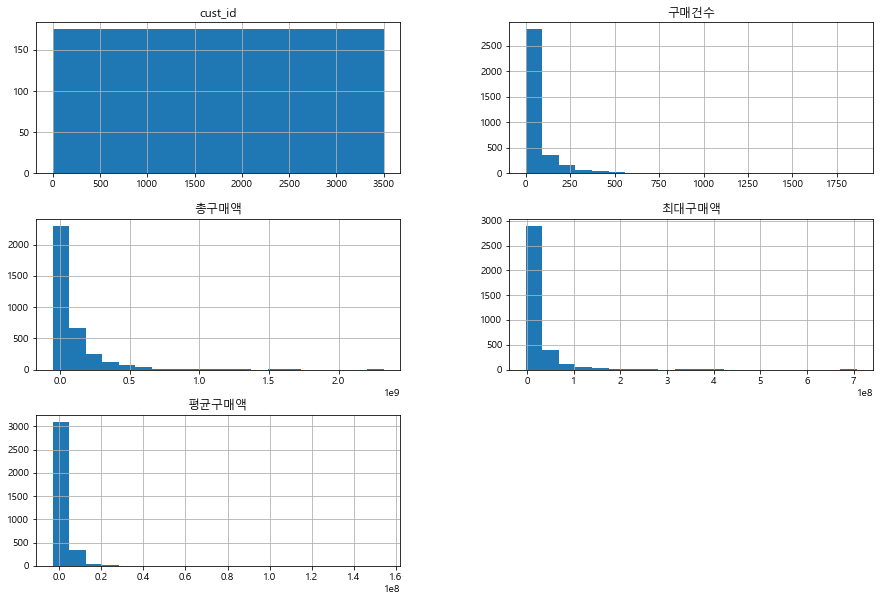

In [7]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 5-7]** 구매상품종류(goods_id, gds_grp_nm, gds_grp_mclas_nm 각각)

In [8]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('구매상품종류1', lambda x: x.nunique())],
    'gds_grp_nm': [('구매상품종류2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('구매상품종류3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3
0,0,68282840,74,922741,11264000,35,28,17
1,1,2136000,3,712000,2136000,2,2,2
2,2,3197000,4,799250,1639000,1,2,2
3,3,16077620,44,365400,4935000,24,20,13
4,4,29050000,3,9683333,24000000,2,3,3
...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2
3496,3496,29628600,13,2279123,7200000,9,7,5
3497,3497,75000,1,75000,75000,1,1,1
3498,3498,1875000,2,937500,1000000,1,1,1


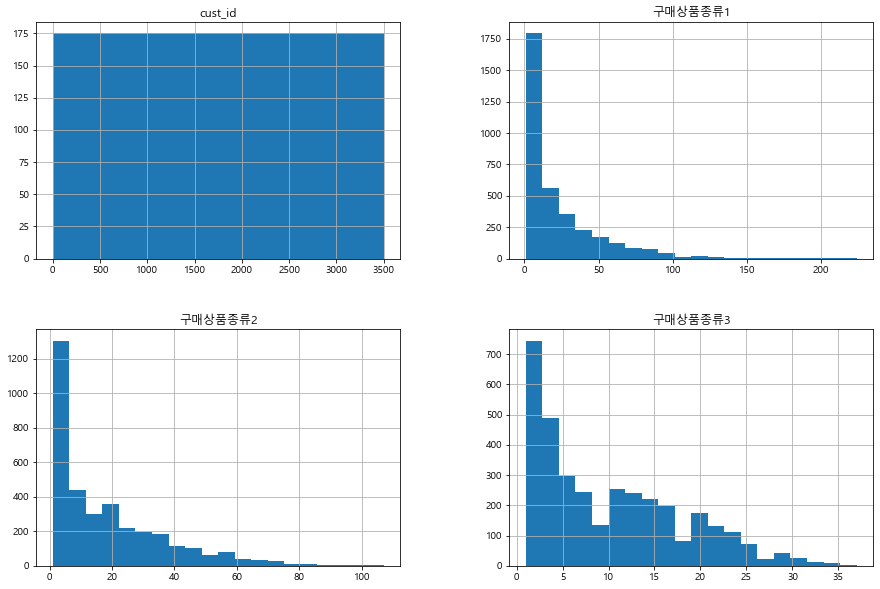

In [9]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 8-14]** 내점일수, 구매주기, 주말방문비율, 계절별 구매비율(Spring(3-5)/Summer(6-8)/Fall(9-11)/Winter(12-2))

In [10]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('내점일수',lambda x: x.str[:10].nunique()),
    ('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique())),
    ('주말방문비율', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4)),
    ('봄-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000


**[파생변수 15-16]** 환불금액, 환불건수

In [11]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([
    ('환불금액', lambda x: x.sum() * -1),
    ('환불건수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN


**[파생변수 17-18]** 내점 당 구매액, 구매건수

In [13]:
visits

cust_id
0       19
1        2
2        2
3       18
4        2
        ..
3495     1
3496     8
3497     1
3498     2
3499    38
Name: tran_date, Length: 3500, dtype: int64

In [14]:
# 내점 당 구매액 = 총구매액 / 내점일수
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "내점당구매액"})
features = features.merge(f, how='left'); features
f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "내점당구매건수"})
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,3.175200e+06,2.000000
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0,3.703575e+06,1.625000
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,7.500000e+04,1.000000
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN,9.375000e+05,1.000000


**[파생변수 19-24]** 최근 3개월, 6개월, 12개월 구매금액 및 구매건수

In [15]:
# pd.to_datetime(), pd.offsets.MonthBegin(3)
for m in [3,6,12]:
    start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(m))
    f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'최근{m}개월_구매금액', np.sum), 
        (f'최근{m}개월_구매건수', np.size)
    ]).reset_index()
    display(f)
    features = features.merge(f, how='left'); features

,cust_id,최근3개월_구매금액,최근3개월_구매건수
0,0,29084140,27
1,1,2136000,3
2,3,549620,4
3,4,27000000,2
4,7,140818200,36
...,...,...,...
2439,3492,9154000,1
2440,3493,42697460,101
2441,3494,82800000,2
2442,3496,12028000,7


,cust_id,최근6개월_구매금액,최근6개월_구매건수
0,0,42601240,61
1,1,2136000,3
2,3,1284060,11
3,4,27000000,2
4,6,2250000,2
...,...,...,...
2778,3492,9154000,1
2779,3493,59972640,140
2780,3494,82800000,2
2781,3496,19224000,11


,cust_id,최근12개월_구매금액,최근12개월_구매건수
0,0,68282840,74
1,1,2136000,3
2,2,3197000,4
3,3,16077620,44
4,4,29050000,3
...,...,...,...
3495,3495,3175200,2
3496,3496,29628600,13
3497,3497,75000,1
3498,3498,1875000,2


<br><font color='green'>
### Categorical Features

**[파생변수 25]** 주구매 상품: 가장 많이 구매한 상품(gds_grp_mclas_nm)

In [16]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,보석
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,NaN,3.175200e+06,2.000000,NaN,NaN,NaN,NaN,3175200,2,골프
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,1.0,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,NaN,7.500000e+04,1.000000,NaN,NaN,NaN,NaN,75000,1,주방용품
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,NaN,9.375000e+05,1.000000,NaN,NaN,NaN,NaN,1875000,2,화장품


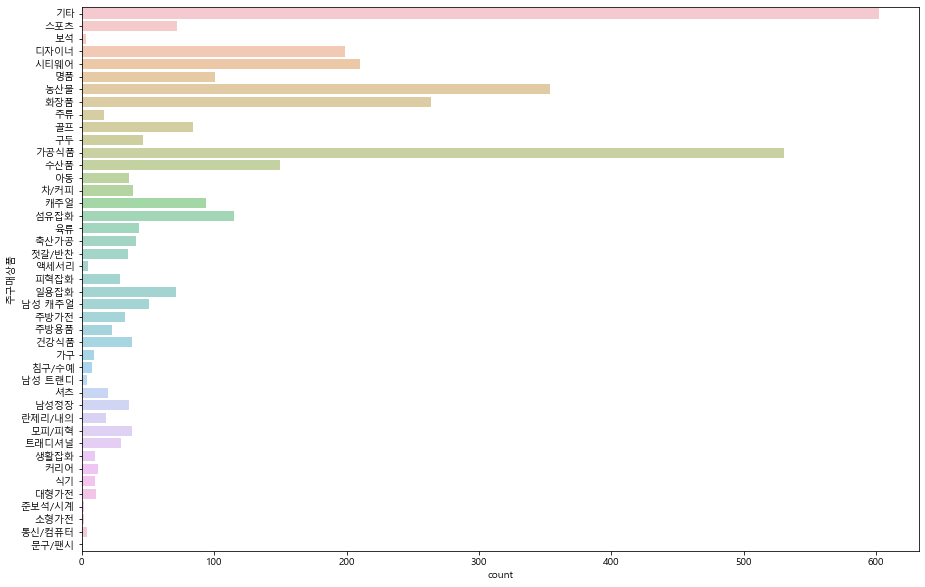

In [17]:
# 범주형 속성 값의 빈도 출력
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='주구매상품', data=f, alpha=0.5)

**[파생변수 26]** 주구매 지점

In [18]:
f = tr.groupby('cust_id')['store_nm'].agg([
    ('주구매지점', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타,관악점
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,보석,본 점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,3.175200e+06,2.000000,NaN,NaN,NaN,NaN,3175200,2,골프,본 점
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,7.500000e+04,1.000000,NaN,NaN,NaN,NaN,75000,1,주방용품,창원점
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,9.375000e+05,1.000000,NaN,NaN,NaN,NaN,1875000,2,화장품,본 점


<br><font color='red'>
**[파생변수 27-35]** 추가로 새로운 파생변수를 제안하고 구현해야 함! 아래는 예시.
- 구매추세 패턴
- 가격선호도 (예: 고가상품구매율)
- 시즌 선호도(어떤 시즌을 가장 선호하는지)
- 휴면(또는 이탈) 여부
- Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부
- 상품별 구매순서
- 주구매 요일 

In [19]:
# 휴면 여부

f = tr.groupby('cust_id')['tran_date'].agg([
    ('휴면_여부', lambda x: int((tr.tran_date.astype('datetime64').max() - x.astype('datetime64').max()).days))
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,휴면_여부
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,7
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,67
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타,관악점,355
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,17
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,보석,본 점,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,2.000000,NaN,NaN,NaN,NaN,3175200,2,골프,본 점,190
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점,11
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,1.000000,NaN,NaN,NaN,NaN,75000,1,주방용품,창원점,363
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,1.000000,NaN,NaN,NaN,NaN,1875000,2,화장품,본 점,270


In [20]:
# 주구매요일

f = tr.groupby('cust_id')['tran_date'].agg([
    ('주구매요일', lambda x: pd.to_datetime(x.value_counts().index[0]).day_name())
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,휴면_여부,주구매요일
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,7,Saturday
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,67,Thursday
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,NaN,NaN,NaN,3197000,4,기타,관악점,355,Monday
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,17,Saturday
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,27000000.0,2.0,27000000.0,2.0,29050000,3,보석,본 점,47,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,NaN,NaN,NaN,NaN,3175200,2,골프,본 점,190,Sunday
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점,11,Tuesday
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,NaN,NaN,NaN,NaN,75000,1,주방용품,창원점,363,Tuesday
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,NaN,NaN,NaN,NaN,1875000,2,화장품,본 점,270,Tuesday


In [21]:
# Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/ 건수/여부
x = []
for i in range(10):
    a= tr.gds_grp_mclas_nm.value_counts().head(10).index[i]
    x.append(a)
x

['기타', '농산물', '가공식품', '축산가공', '수산품', '화장품', '디자이너', '시티웨어', '일용잡화', '육류']

In [22]:
f = tr.query("gds_grp_mclas_nm in {}".format(x)).groupby('cust_id')['amount'].agg([
    ('Top-10 베스트 셀러에 대한 구매 금액', np.sum),
    ('Top-10 베스트 셀러에 대한 구매 건수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,휴면_여부,주구매요일,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,42601240.0,61.0,68282840,74,기타,강남점,7,Saturday,45689940.0,51.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,2136000.0,3.0,2136000,3,스포츠,잠실점,67,Thursday,NaN,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,NaN,3197000,4,기타,관악점,355,Monday,139000.0,2.0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,1284060.0,11.0,16077620,44,기타,광주점,17,Saturday,4411020.0,36.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,27000000.0,2.0,29050000,3,보석,본 점,47,Wednesday,5050000.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,NaN,NaN,3175200,2,골프,본 점,190,Sunday,132300.0,1.0
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,19224000.0,11.0,29628600,13,시티웨어,부산본점,11,Tuesday,14774000.0,10.0
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,NaN,NaN,75000,1,주방용품,창원점,363,Tuesday,NaN,NaN
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,NaN,NaN,1875000,2,화장품,본 점,270,Tuesday,1875000.0,2.0


In [23]:
features['Top-10 베스트 셀러에 대한 구매 여부'] = features['Top-10 베스트 셀러에 대한 구매 금액'].apply(lambda x: 'True' if x > 0 else 'False')
features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,휴면_여부,주구매요일,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수,Top-10 베스트 셀러에 대한 구매 여부
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,61.0,68282840,74,기타,강남점,7,Saturday,45689940.0,51.0,True
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,3.0,2136000,3,스포츠,잠실점,67,Thursday,NaN,NaN,False
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,3197000,4,기타,관악점,355,Monday,139000.0,2.0,True
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,11.0,16077620,44,기타,광주점,17,Saturday,4411020.0,36.0,True
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,2.0,29050000,3,보석,본 점,47,Wednesday,5050000.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,NaN,3175200,2,골프,본 점,190,Sunday,132300.0,1.0,True
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,11.0,29628600,13,시티웨어,부산본점,11,Tuesday,14774000.0,10.0,True
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,NaN,75000,1,주방용품,창원점,363,Tuesday,NaN,NaN,False
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,NaN,1875000,2,화장품,본 점,270,Tuesday,1875000.0,2.0,True


In [24]:
a = features['봄-구매비율']
b = features['여름-구매비율']
c = features['가을-구매비율']
d = features['겨울-구매비율']
features['시즌 선호도']= "Nan"
for i in range(3500):
    e = [a[i],b[i],c[i],d[i]]
    if max(e) == a[i]:
        features['시즌 선호도'][i] = '봄'
    elif max(e) == b[i]:
        features['시즌 선호도'][i] = '여름'
    elif max(e) == c[i]:
        features['시즌 선호도'][i] = '가을'
    else:
        features['시즌 선호도'][i] = '겨울'

C:\Download\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Download\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Download\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp

In [25]:
features['시즌 선호도']

0       여름
1       가을
2       겨울
3        봄
4       가을
        ..
3495    여름
3496    가을
3497    겨울
3498     봄
3499    여름
Name: 시즌 선호도, Length: 3500, dtype: object

Top-10 베스트 셀러에 대한 구매를 feature로 만들다 보니 Top-10 베스트 셀러 안에서 성별을 구별할 수 있는 품목을 두 가지 정도 추정했다.
바로 농산물하고 화장품 부분이다. 그래서 이 부분들을 Top-10 베스트 셀러에 대한 구매 금액/건수/여부 코드를 인용해서
농산물하고 화장품 부분을 feature로 만들게 되었다.

In [26]:
f = tr.query('gds_grp_mclas_nm == "화장품"').groupby('cust_id')['amount'].agg([
    ('화장품 구매금액', np.sum),
    ('화장품 구매건수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주구매상품,주구매지점,휴면_여부,주구매요일,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수,Top-10 베스트 셀러에 대한 구매 여부,시즌 선호도,화장품 구매금액,화장품 구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,기타,강남점,7,Saturday,45689940.0,51.0,True,여름,22450000.0,7.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,스포츠,잠실점,67,Thursday,NaN,NaN,False,가을,NaN,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,기타,관악점,355,Monday,139000.0,2.0,True,겨울,NaN,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,기타,광주점,17,Saturday,4411020.0,36.0,True,봄,NaN,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,보석,본 점,47,Wednesday,5050000.0,2.0,True,가을,2050000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,골프,본 점,190,Sunday,132300.0,1.0,True,여름,NaN,NaN
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,시티웨어,부산본점,11,Tuesday,14774000.0,10.0,True,가을,NaN,NaN
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,주방용품,창원점,363,Tuesday,NaN,NaN,False,겨울,NaN,NaN
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,화장품,본 점,270,Tuesday,1875000.0,2.0,True,봄,1875000.0,2.0


In [27]:
features['화장품에 대한 구매 여부'] = features['화장품 구매금액'].apply(lambda x: 'True' if x > 0 else 'False')
features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주구매지점,휴면_여부,주구매요일,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수,Top-10 베스트 셀러에 대한 구매 여부,시즌 선호도,화장품 구매금액,화장품 구매건수,화장품에 대한 구매 여부
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,강남점,7,Saturday,45689940.0,51.0,True,여름,22450000.0,7.0,True
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,잠실점,67,Thursday,NaN,NaN,False,가을,NaN,NaN,False
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,관악점,355,Monday,139000.0,2.0,True,겨울,NaN,NaN,False
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,광주점,17,Saturday,4411020.0,36.0,True,봄,NaN,NaN,False
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,본 점,47,Wednesday,5050000.0,2.0,True,가을,2050000.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,본 점,190,Sunday,132300.0,1.0,True,여름,NaN,NaN,False
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,부산본점,11,Tuesday,14774000.0,10.0,True,가을,NaN,NaN,False
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,창원점,363,Tuesday,NaN,NaN,False,겨울,NaN,NaN,False
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,본 점,270,Tuesday,1875000.0,2.0,True,봄,1875000.0,2.0,True


In [28]:
f = tr.query('gds_grp_mclas_nm == "농산물"').groupby('cust_id')['amount'].agg([
    ('농산품 구매금액', np.sum),
    ('농산품 구매건수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주구매요일,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수,Top-10 베스트 셀러에 대한 구매 여부,시즌 선호도,화장품 구매금액,화장품 구매건수,화장품에 대한 구매 여부,농산품 구매금액,농산품 구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,Saturday,45689940.0,51.0,True,여름,22450000.0,7.0,True,74360.0,3.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,Thursday,NaN,NaN,False,가을,NaN,NaN,False,NaN,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,Monday,139000.0,2.0,True,겨울,NaN,NaN,False,NaN,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,Saturday,4411020.0,36.0,True,봄,NaN,NaN,False,1599380.0,6.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,Wednesday,5050000.0,2.0,True,가을,2050000.0,1.0,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,Sunday,132300.0,1.0,True,여름,NaN,NaN,False,NaN,NaN
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,Tuesday,14774000.0,10.0,True,가을,NaN,NaN,False,NaN,NaN
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,Tuesday,NaN,NaN,False,겨울,NaN,NaN,False,NaN,NaN
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,Tuesday,1875000.0,2.0,True,봄,1875000.0,2.0,True,NaN,NaN


In [29]:
features['농산품에 대한 구매 여부'] = features['농산품 구매금액'].apply(lambda x: 'True' if x > 0 else 'False')
features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수,Top-10 베스트 셀러에 대한 구매 여부,시즌 선호도,화장품 구매금액,화장품 구매건수,화장품에 대한 구매 여부,농산품 구매금액,농산품 구매건수,농산품에 대한 구매 여부
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,45689940.0,51.0,True,여름,22450000.0,7.0,True,74360.0,3.0,True
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,NaN,NaN,False,가을,NaN,NaN,False,NaN,NaN,False
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,139000.0,2.0,True,겨울,NaN,NaN,False,NaN,NaN,False
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,4411020.0,36.0,True,봄,NaN,NaN,False,1599380.0,6.0,True
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,5050000.0,2.0,True,가을,2050000.0,1.0,True,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,132300.0,1.0,True,여름,NaN,NaN,False,NaN,NaN,False
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,14774000.0,10.0,True,가을,NaN,NaN,False,NaN,NaN,False
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,NaN,NaN,False,겨울,NaN,NaN,False,NaN,NaN,False
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,1875000.0,2.0,True,봄,1875000.0,2.0,True,NaN,NaN,False


<br><font color='green'>
### Feature Correlation

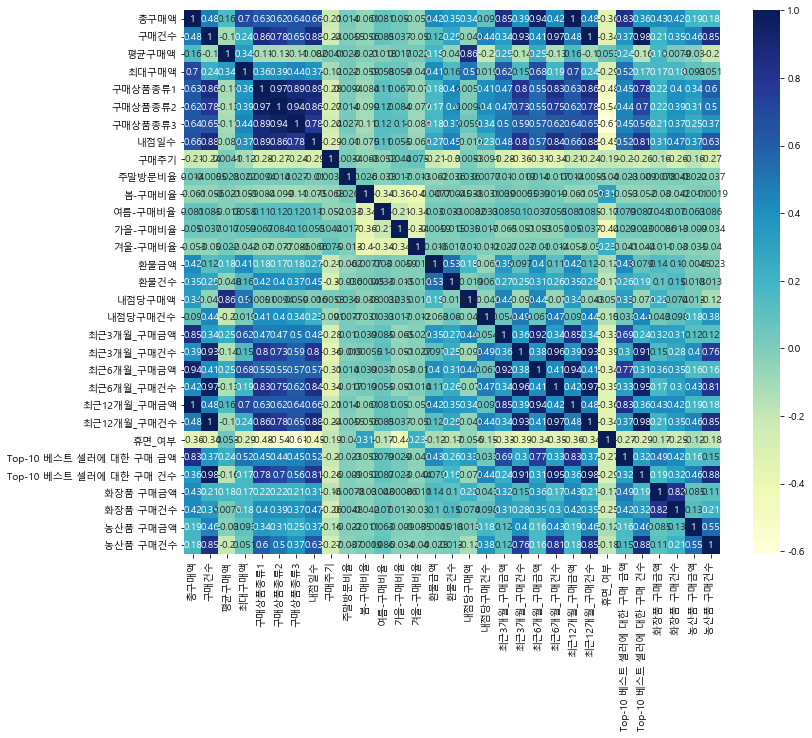

In [30]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악 
plt.figure(figsize=(12,10))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

## Save Features
- 아래 코드를 수행하면 생성한 모든 파생변수가 CSV 화일로 만들어진다.

In [31]:
display(features)
features.to_csv('features.csv', index=False, encoding='cp949')
features.info()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수,Top-10 베스트 셀러에 대한 구매 여부,시즌 선호도,화장품 구매금액,화장품 구매건수,화장품에 대한 구매 여부,농산품 구매금액,농산품 구매건수,농산품에 대한 구매 여부
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,45689940.0,51.0,True,여름,22450000.0,7.0,True,74360.0,3.0,True
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,NaN,NaN,False,가을,NaN,NaN,False,NaN,NaN,False
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,139000.0,2.0,True,겨울,NaN,NaN,False,NaN,NaN,False
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,4411020.0,36.0,True,봄,NaN,NaN,False,1599380.0,6.0,True
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,5050000.0,2.0,True,가을,2050000.0,1.0,True,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,132300.0,1.0,True,여름,NaN,NaN,False,NaN,NaN,False
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,14774000.0,10.0,True,가을,NaN,NaN,False,NaN,NaN,False
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,NaN,NaN,False,겨울,NaN,NaN,False,NaN,NaN,False
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,1875000.0,2.0,True,봄,1875000.0,2.0,True,NaN,NaN,False


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 0 to 3499
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cust_id                  3500 non-null   int64  
 1   총구매액                     3500 non-null   int64  
 2   구매건수                     3500 non-null   int64  
 3   평균구매액                    3500 non-null   int64  
 4   최대구매액                    3500 non-null   int64  
 5   구매상품종류1                  3500 non-null   int64  
 6   구매상품종류2                  3500 non-null   int64  
 7   구매상품종류3                  3500 non-null   int64  
 8   내점일수                     3500 non-null   int64  
 9   구매주기                     3500 non-null   int64  
 10  주말방문비율                   3500 non-null   float64
 11  봄-구매비율                   3500 non-null   float64
 12  여름-구매비율                  3500 non-null   float64
 13  가을-구매비율                  3500 non-null   float64
 14  겨울-구매비율                 

# End

In [31]:
!pip install shap

In [52]:
import shap

In [51]:
# library import
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [34]:
# 현재경로 확인
os.getcwd()

# 데이터 불러오기
data = pd.read_csv("transactions.csv", encoding='cp949') 
data.head() # 데이터 확인

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


In [53]:
# shape 파악
nCar = data.shape[0] # 데이터 개수
nVar = data.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 232004 nVar: 7


In [36]:
# 데이터 불러오기
data1 = pd.read_csv("target.csv") 
data1.head() # 데이터 확인

,cust_id,gender
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


In [55]:
X = features1
y = data1['gender']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42) 
# train/test 비율을 7:3
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 확인

(2450, 36) (1050, 36) (2450,) (1050,)


In [73]:
!pip install lightgbm

In [56]:
# lightgbm을 구현하여 shap value를 예측할 것
# ligthgbm 구현

# library
import lightgbm as lgb  # 없을 경우 cmd/anaconda prompt에서 install
from math import sqrt
from sklearn.metrics import mean_squared_error

# lightgbm model
lgb_dtrain = lgb.Dataset(data = train_x, label = train_y) # LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10,
            'learning_rate': 0.01, # Step Size
            'n_estimators': 1000, # Number of trees
            'objective': 'regression'} # 목적 함수 (L2 Loss)
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = lgb_model.predict(test_x) # test data 예측
print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, test_y)))) # RMSE

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6423
[LightGBM] [Info] Number of data points in the train set: 2450, number of used features: 36
[LightGBM] [Info] Start training from score 0.382449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [42]:
features1['Top-10 베스트 셀러에 대한 구매 여부'] = features1['Top-10 베스트 셀러에 대한 구매 여부'].map({'False': 0, 'True': 1})
features1['Top-10 베스트 셀러에 대한 구매 여부']

0       1
1       0
2       1
3       1
4       1
       ..
3495    1
3496    1
3497    0
3498    1
3499    1
Name: Top-10 베스트 셀러에 대한 구매 여부, Length: 3500, dtype: int64

In [43]:
features1['시즌 선호도'] = features1['시즌 선호도'].map({'봄': 0, '여름': 1, '가을' :2,'겨울':3})

In [44]:
features1['농산품에 대한 구매 여부'] = features1['농산품에 대한 구매 여부'].map({'False': 0, 'True': 1})
features1['화장품에 대한 구매 여부'] = features1['화장품에 대한 구매 여부'].map({'False': 0, 'True': 1})

In [46]:
# del features1['주구매상품']
del features1['주구매요일']
del features1['주구매지점']

In [ ]:
DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields:
주구매상품, 주구매지점, 주구매요일, Top-10 베스트 셀러에 대한 구매 여부, 시즌 선호도
화장품에 대한 구매 여부, 농산품에 대한 구매 여부

In [38]:
features1 = features.copy()
del features1['주구매상품']

In [57]:
features1.fillna(0)

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수,Top-10 베스트 셀러에 대한 구매 여부,시즌 선호도,화장품 구매금액,화장품 구매건수,화장품에 대한 구매 여부,농산품 구매금액,농산품 구매건수,농산품에 대한 구매 여부
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,45689940.0,51.0,1,1,22450000.0,7.0,1,74360.0,3.0,1
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.0,0.0,0,2,0.0,0.0,0,0.0,0.0,0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,139000.0,2.0,1,3,0.0,0.0,0,0.0,0.0,0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,4411020.0,36.0,1,0,0.0,0.0,0,1599380.0,6.0,1
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,5050000.0,2.0,1,2,2050000.0,1.0,1,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,132300.0,1.0,1,1,0.0,0.0,0,0.0,0.0,0
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,14774000.0,10.0,1,2,0.0,0.0,0,0.0,0.0,0
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,0.0,0.0,0,3,0.0,0.0,0,0.0,0.0,0
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,1875000.0,2.0,1,0,1875000.0,2.0,1,0.0,0.0,0


In [47]:
features1

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,Top-10 베스트 셀러에 대한 구매 금액,Top-10 베스트 셀러에 대한 구매 건수,Top-10 베스트 셀러에 대한 구매 여부,시즌 선호도,화장품 구매금액,화장품 구매건수,화장품에 대한 구매 여부,농산품 구매금액,농산품 구매건수,농산품에 대한 구매 여부
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,45689940.0,51.0,1,1,22450000.0,7.0,1,74360.0,3.0,1
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,NaN,NaN,0,2,NaN,NaN,0,NaN,NaN,0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,139000.0,2.0,1,3,NaN,NaN,0,NaN,NaN,0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,4411020.0,36.0,1,0,NaN,NaN,0,1599380.0,6.0,1
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,5050000.0,2.0,1,2,2050000.0,1.0,1,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,132300.0,1.0,1,1,NaN,NaN,0,NaN,NaN,0
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,14774000.0,10.0,1,2,NaN,NaN,0,NaN,NaN,0
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,NaN,NaN,0,3,NaN,NaN,0,NaN,NaN,0
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,1875000.0,2.0,1,0,1875000.0,2.0,1,NaN,NaN,0


In [58]:
features1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 0 to 3499
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cust_id                  3500 non-null   int64  
 1   총구매액                     3500 non-null   int64  
 2   구매건수                     3500 non-null   int64  
 3   평균구매액                    3500 non-null   int64  
 4   최대구매액                    3500 non-null   int64  
 5   구매상품종류1                  3500 non-null   int64  
 6   구매상품종류2                  3500 non-null   int64  
 7   구매상품종류3                  3500 non-null   int64  
 8   내점일수                     3500 non-null   int64  
 9   구매주기                     3500 non-null   int64  
 10  주말방문비율                   3500 non-null   float64
 11  봄-구매비율                   3500 non-null   float64
 12  여름-구매비율                  3500 non-null   float64
 13  가을-구매비율                  3500 non-null   float64
 14  겨울-구매비율                 

In [94]:
features1["화장품 구매금액"] = features1["화장품 구매금액"].fillna(0)
# X.Age = X.Age.fillna(X.Age.mean())

In [96]:
del features1['주구매지점']
del features1['주구매요일']

In [122]:
features.query('화장품에 대한 구매 여부')

SyntaxError: invalid syntax (<unknown>, line 1)

In [97]:
del features1['Top-10 베스트 셀러에 대한 구매 여부']
del features1['시즌 선호도']
del features1['화장품에 대한 구매 여부']
del features1['농산품에 대한 구매 여부']

In [59]:
# shap value를 이용하여 각 변수의 영향도 파악

# !pip install shap (에러 발생시, skimage version 확인 (0.14.2 이상 권장))
# import skimage -> skimage.__version__ (skimage version 확인)
# skimage version upgrade -> !pip install --upgrade scikit-image

# shap value 
import shap
explainer = shap.TreeExplainer(lgb_model) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(test_x) # Shap Values 계산

In [64]:
# version 확인
import skimage
skimage.__version__

'0.17.2'

In [60]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], test_x.iloc[1,:])

In [61]:
# 전체 검증 데이터 셋에 대해서 적용
shap.force_plot(explainer.expected_value, shap_values, test_x) 

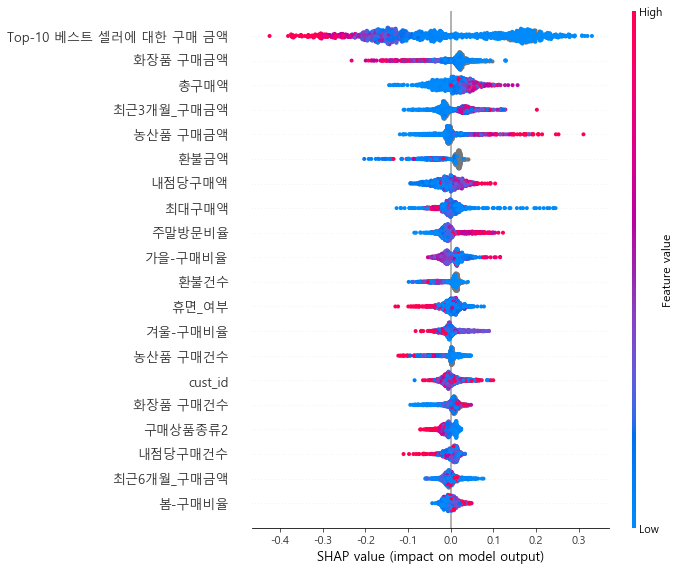

In [62]:
# summary
shap.summary_plot(shap_values, test_x)

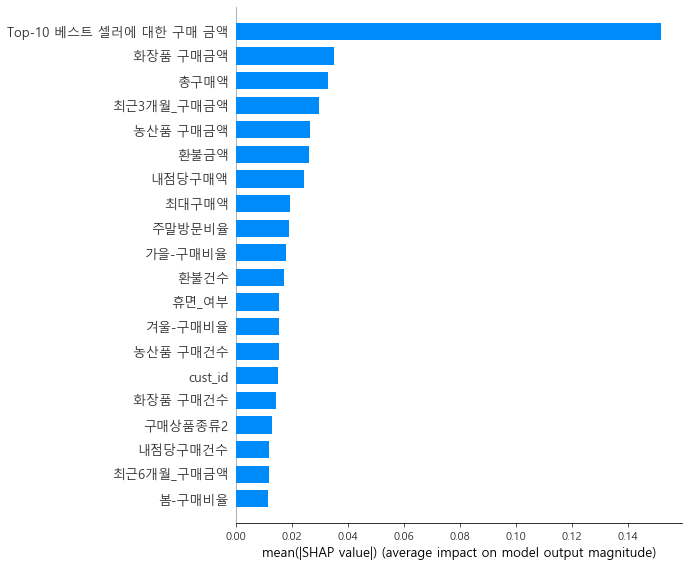

In [63]:
 # 각 변수에 대한 |Shap Values|을 통해 변수 importance 파악
shap.summary_plot(shap_values, test_x, plot_type = "bar")

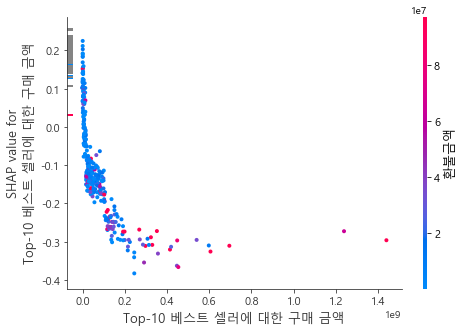

In [105]:
# 변수 간의 shap value 파악
shap.dependence_plot("Top-10 베스트 셀러에 대한 구매 금액", shap_values, test_x)